In [8]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# 애국가 예제 텍스트
text = """
동해 물과 백두산이 마르고 닳도록 하느님이 보우하사 우리나라 만세
무궁화 삼천리 화려강산 대한 사람 대한으로 길이 보전하세
남산 위에 저 소나무 철갑을 두른 듯 바람 서리 불변함은 우리 기상일세
무궁화 삼천리 화려강산 대한 사람 대한으로 길이 보전하세
"""

# Tokenizer 적용
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
token_list = tokenizer.texts_to_sequences([text])[0]
word_index = tokenizer.word_index
total_words = len(word_index) + 1
print("total words:", total_words)

total words: 30


In [9]:
### 오직 출력용으로 
vocab_size = len(word_index) + 1
emb = 8

first_5_words = text.strip().split()[:5]
first_5_tokens = token_list[:5]

for word, token in zip(first_5_words, first_5_tokens):
    print(f"'{word}' → {token}")

input_layer = Input(shape=(1,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emb, input_length=1)
embedded = embedding_layer(input_layer)
embedding_model = Model(inputs=input_layer, outputs=embedded)

print("\n단어\t→ 토큰\t→ 임베딩 벡터:")
for word, token in zip(first_5_words, first_5_tokens):
    token_array = np.array([[token]])
    embedding_vector = embedding_model.predict(token_array, verbose=0)[0][0]
    print(f"{word}\t→ {token}\t→ {np.round(embedding_vector, 3)}")

'동해' → 9
'물과' → 10
'백두산이' → 11
'마르고' → 12
'닳도록' → 13

단어	→ 토큰	→ 임베딩 벡터:
동해	→ 9	→ [-0.036 -0.048 -0.025  0.034 -0.043 -0.014  0.003  0.045]
물과	→ 10	→ [ 0.045 -0.047 -0.013 -0.013 -0.001 -0.046  0.014  0.01 ]
백두산이	→ 11	→ [-0.007 -0.015  0.036  0.033 -0.007 -0.035  0.021  0.01 ]
마르고	→ 12	→ [-0.04   0.007 -0.02  -0.012 -0.024  0.039  0.042 -0.032]
닳도록	→ 13	→ [ 0.037  0.023  0.033 -0.048  0.048  0.002  0.003  0.028]


In [10]:
# 모델 B: Many-to-many 데이터
output_len = 5
X, y = [], []
for i in range(len(token_list) - 5 - output_len + 1):
    X.append(token_list[i:i+5])
    y.append(token_list[i+5:i+5+output_len])
X = np.array(X)
y = tf.keras.utils.to_categorical(y, num_classes=total_words)


# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 정의
embedding_dim = 16
dnn_units = 32
lstm_units = 64

# 모델 정의
model = Sequential([
    Embedding(total_words, embedding_dim),
    LSTM(lstm_units, return_sequences=True),
    TimeDistributed(Dense(dnn_units , activation='relu')),
    TimeDistributed(Dense(total_words, activation='softmax'))
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# 학습
history = model.fit(X_train, y_train, epochs=100,verbose=0)

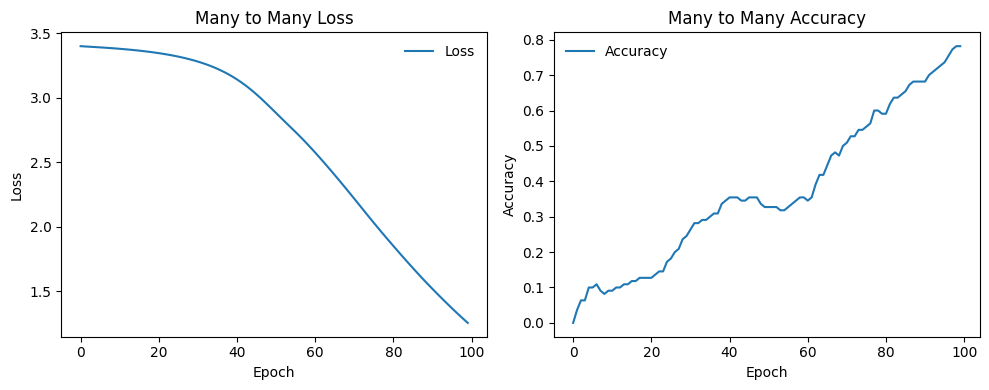

In [11]:
import matplotlib.pyplot as plt

# ▶ 학습 이력 시각화 함수
def plot_history(history, title="Model"):
    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(frameon=False)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

plot_history(history, title="Many to Many")

In [12]:
# 테스트 정확도 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.5000


In [13]:
def generate_many(seed_text):
    token_seq = tokenizer.texts_to_sequences([seed_text])[0]
    token_seq = pad_sequences([token_seq], maxlen=5, padding='pre')  # shape: (1, 5)
    
    # model_b expects input shape (None, 5)
    pred = model.predict(token_seq, verbose=0)[0]  # shape: (5, vocab_size)
    
    result = seed_text
    for i in range(pred.shape[0]):
        next_word_index = np.argmax(pred[i])
        next_word = tokenizer.index_word.get(next_word_index, '')
        result += ' ' + next_word
    return result


In [14]:
seed = "동해 물과 백두산이 마르고"

print("\nMany-to-many (5단어 동시 생성):")
print(generate_many(seed))



Many-to-many (5단어 동시 생성):
동해 물과 백두산이 마르고 무궁화 무궁화 저 저 무궁화
